In [21]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [22]:
import torch 
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

In [23]:
torch.cuda.is_available()

True

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
learning_rate = 1e-3
batch_size = 64
num_epochs = 20
noise_factor = 0.5

In [26]:
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])
transform = transforms.ToTensor()
trainset = datasets.MNIST(root='./data',train=True, download=True,transform=transform)
testset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [27]:
def addnoise(img,noise_factor):
  img_noisy = img + noise_factor * torch.randn(img.shape)
  # img_noisy = np.clip(img_noisy, 0., 1.)
  return img_noisy

In [28]:
class Autoencoder(nn.Module):
  def __init__(self):
    
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1,16,3, stride = 2, padding = 1),
      nn.ReLU(),
      nn.Conv2d(16,32,3, stride = 2, padding = 1),
      nn.ReLU(),
      nn.Conv2d(32,64,7)
    )
    
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(64,32,7), 
      nn.ReLU(),
      nn.ConvTranspose2d(32,16,3, stride = 2, padding=1, output_padding = 1),
      nn.ReLU(),
      nn.ConvTranspose2d(16,1,3, stride = 2, padding=1, output_padding = 1),
      nn.Sigmoid()
  )

  def forward(self,input):
    encoded_img = self.encoder(input)
    decoded_img = self.decoder(encoded_img)
    return decoded_img

In [29]:
net = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay= 1e-5)


In [30]:
net.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [31]:
train_loss = []
for epoch in range(num_epochs):
  curr_loss = 0
  for (img,_) in trainloader:
    img_noisy = addnoise(img,0.5)
    img_noisy = img_noisy.to(device)
    img = img.to(device)
    output = net(img_noisy)
    loss = criterion(output,img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  print(f'Epoch:{epoch+1}/{num_epochs}, Loss:{loss.item():.3f}')

Epoch:1/20, Loss:0.020
Epoch:2/20, Loss:0.016
Epoch:3/20, Loss:0.011
Epoch:4/20, Loss:0.011
Epoch:5/20, Loss:0.011
Epoch:6/20, Loss:0.012
Epoch:7/20, Loss:0.012
Epoch:8/20, Loss:0.011
Epoch:9/20, Loss:0.009
Epoch:10/20, Loss:0.011
Epoch:11/20, Loss:0.011
Epoch:12/20, Loss:0.009
Epoch:13/20, Loss:0.011
Epoch:14/20, Loss:0.009
Epoch:15/20, Loss:0.011
Epoch:16/20, Loss:0.010
Epoch:17/20, Loss:0.012
Epoch:18/20, Loss:0.012
Epoch:19/20, Loss:0.009
Epoch:20/20, Loss:0.011


In [32]:
# print(train_loss)


Text(0, 0.5, 'loss')

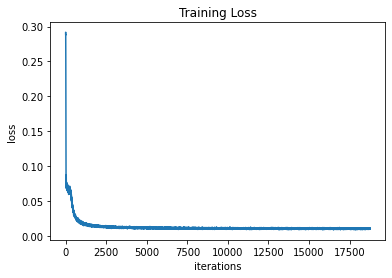

In [33]:
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("iterations")
plt.ylabel("loss")

In [34]:
img_noisy = img_noisy.cpu()
output = output.cpu()
img = img.cpu()


In [35]:
img  = img.reshape(-1,28,28)
img  = img.detach().numpy()

In [36]:
img_noisy  = img_noisy.reshape(-1,28,28)
img_noisy  = img_noisy.detach().numpy()
  

In [37]:
output = output.detach().numpy()
output = output.reshape(-1,28,28)

In [38]:
flatten = nn.Flatten()
def cosine_similarity(inputs, targets):
    inputs = flatten(inputs).detach().cpu().numpy()
    inputs = inputs / np.linalg.norm(inputs)
    targets = flatten(targets).detach().cpu().numpy()
    targets = targets / np.linalg.norm(targets)
    products = inputs.dot(targets.T)
    return products 

In [39]:
iterer = next(iter(testset))
total = 0
sum = 0
with torch.no_grad():
  for i in iterer[0]:
    total += 1
    
    i = i.to(device).reshape((1,i.shape[0],i.shape[1]))
    sum += cosine_similarity(net(i.to(device)), i)
  print(sum/total)

[[0.9815]]


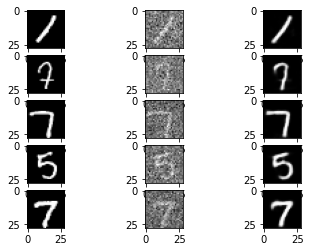

In [40]:
for i in range(1,6):
  #plt.figure(figsize=(10,10))
  plt.subplot(5,3,(i*3)-2)
  plt.imshow(img[i],cmap='gray')


for i in range(1,6):
  # plt.figure(figsize=(10,10))
  plt.subplot(5,3,(i*3)-1)
  plt.imshow(img_noisy[i],cmap='gray')
  # plt.figure(figsize=(1,1))
for j in range(1,6):
  # plt.figure(figsize=(10,10))
  plt.subplot(5,3,j*3)
  plt.imshow(output[j],cmap='gray')
  # plt.figure(figsize=(1,1))
